# Description

This notebook uses the observation-based median-scaled maximum temperature distributions to evaluate discrete probability ratios between the modern warming period (i.e., the "forced" period) and the counterfactual (related to the "natural" period); for more information on these periods and their global means, see [hadcrut_GMST.ipynb](hadcrut_GMST.ipynb).

The probability ratios (PRs)---calculated as a function of specific quantiles or query maximum temperatures---are used as estimates of the attributable changes at each location and month; in this notebook we plot the monthly maps of median-scaling-derived PRs.

**FIGURES PRODUCED IN THIS CODE**
* [Fig. S5](./paper_figures/si/figS5.pdf)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import utilities as util
import analysisfx as analysis
from calendar import monthrange

# ignore depreciation warnings in this code
import warnings
warnings.filterwarnings("ignore")

# define the locations to save the figures into
fig_si_savepath='./paper_figures/si/'

In [2]:
# set up things for plots
monstr=['J','F','M','A','M','J','J','A','S','O','N','D']
cmapgray=plt.get_cmap('viridis').copy()
cmapgray.set_under(color="gray",alpha=0.5)

# Load Data

### Load+Organize Expected Number of Counts Metadata

In [2]:
# load expected number of counts metadata from pathway
natcountspath='./data/analysis/Ndays_Expected.nc'
natcountdat=xr.open_dataset(natcountspath)

In [9]:
# choose and check the quantile of interest
qq=95
pp=qq/100

# Define a data-slicing function to coordinate with the expected number of counts metadata
# Function to subset the natcount data structure along a single specific quantile
def get_quantile_natcounts(qi,natcountdat):
    # slice the data along the chosen quantile
    ppi=natcountdat.sel(pp=slice(qi-1e-6,qi+1e-6))
    if len(ppi.pp)!=1:
        print(len(ppi.pp))
        raise ValueError("Too many chosen quantiles")
    # go back to the above program level
    return(ppi)

# test the function and grab the chosen quantile dataset
ppitest=get_quantile_natcounts(qq,natcountdat)
# print the test to screen
display(ppitest)

# define a quantile grid for analyses
qgrid=np.array([90,95,96.7,97.5,99])
ppgrid=qgrid/100

<xarray.Dataset>
Dimensions:              (pp: 1, mon: 12, seas: 4)
Coordinates:
  * pp                   (pp) float64 95.0
  * mon                  (mon) object 'J' 'F' 'M' 'A' 'M' ... 'S' 'O' 'N' 'D'
  * seas                 (seas) object 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    MonthlyExceedance    (pp, mon) float64 ...
    MonthlySubceedance   (pp, mon) float64 ...
    SeasonalExceedance   (pp, seas) float64 ...
    SeasonalSubceedance  (pp, seas) float64 ...
    AnnualExceedance     (pp) float64 ...
    AnnualSubceedance    (pp) float64 ...
Attributes:
    Dataset Unit:  Number of Days Equal to or Exceeding OR Subceeding the per...

### Setup Loading Distribution Data

In [5]:
# set up scaled distributions data info
dist_loadpath='/home/dgilford/fingerprints/data/analysis/paper/scaled_distributions/q50/'
saveprefix='q50_BE_scaledTdist_'
savesuffix='.zarr'

### Load in the Berkeley data land-sea mask

In [6]:
# define the path and load the lsm
lsm_loadpath='/home/dgilford/fingerprints/data/analysis/paper/berkeley_lsm.nc'
lsm=xr.open_dataset(lsm_loadpath)

# Monthly Exceedances

/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/dgilford/.conda/envs/att/lib/

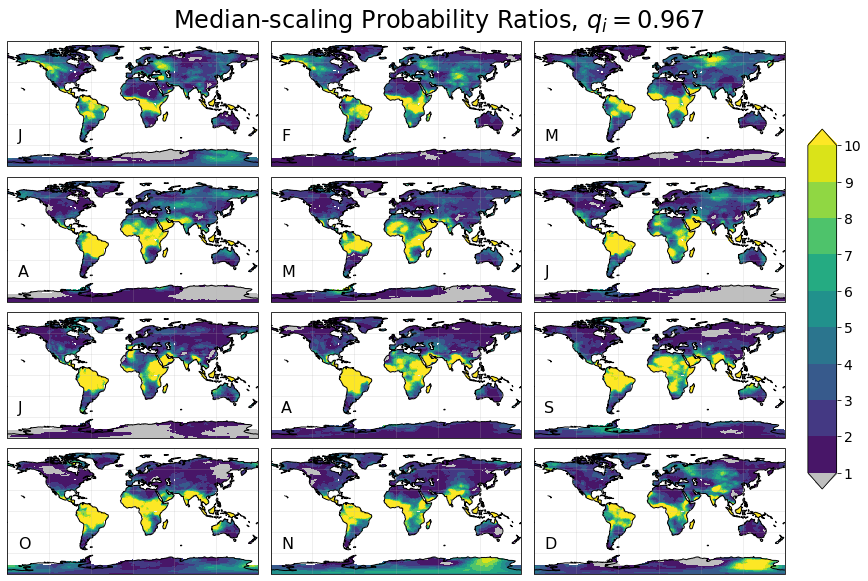

NameError: name 'qjdat' is not defined

In [7]:
# loop over quantiles of interest
for qj in np.array([ppgrid[2]]):
    
    # set up plots for this quantile
    fig=plt.figure(figsize=(16,10))
#     exceedance_savename='q50_exceedances_'+str(qj*100).zfill(2)+'perc_mon01-12.pdf'
    pr_savename='q50_PRmap_'+str(qj*100).zfill(2)+'perc_mon01-12.pdf'
    
    # get the natcounts from the quantiles
    #qjdat=get_quantile_natcounts(qj*100,natcountdat)

    # loop over all the months
    for mi in np.arange(1,13):

        # get the name and load data
        zarrname=saveprefix+str(mi).zfill(2)+savesuffix
        datin=util.load_zarr_local(dist_loadpath,zarrname,chunks=-1)
        
        # get the monthly temperature threshold (from Natural) associated with the quantile
        Tthresh_qj=datin.natural.quantile(qj,dim='time')
        
        # find the locations where we exceed the natural threshold (where)
        # then group those values by year at each location
        # then count how many are valid at each location
        # then take an average over all years
        forced_counts_qj=datin.forced107.where(datin.forced107>Tthresh_qj).groupby('time.year').count(dim='time').mean('year')
        del datin
        
        # copy the array and fill it with natural counts
        mon_default_counts=util.nat_exceed(qj*100,monthrange(2015, mi)[1])
        #default_mon_count=qjdat.MonthlyExceedance[0,mi-1].values.flatten()[0]
        natural_counts_qj=xr.full_like(forced_counts_qj.copy(deep='True'),mon_default_counts)
        
        # calculate the probability ratio (PR)
        PR_qj=forced_counts_qj/natural_counts_qj
        
        # fill all ocean areas (with land-sea mask) with missing
        forced_counts_qj=forced_counts_qj.where(lsm==True).rename({'lsm':'forced'})
        natural_counts_qj=natural_counts_qj.where(lsm==True).rename({'lsm':'natural'})
        PR_qj=PR_qj.where(lsm==True).rename({'lsm':'PR'})
    
        ## PLOT
        # wrap around the prime meridian before plotting
        PR_qj_cyc = util.add_cyclic_point(PR_qj.PR, 'lon')
    
        # plot the result
        ax = plt.subplot(4, 3, mi, projection=ccrs.PlateCarree())

        levs=np.arange(1,10+1,1)
        datp=ax.contourf(PR_qj_cyc.lon,PR_qj_cyc.lat,PR_qj_cyc, \
                            levels=levs, transform=ccrs.PlateCarree(), \
                            cmap=cmapgray, extend='both')

        # draw the coastlines
        ax.coastlines()
        ax.gridlines(alpha=0.25)
        
        # add the month string
        plt.text(-165,-53,monstr[mi-1],fontsize=16,transform=ccrs.PlateCarree())
        
        # clean up
        PR_qj, PR_qj_cyc, forced_counts_qj, natural_counts_qj
    

    # adjust the white space between the subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.)

    # make a single large colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.25, 0.025, 0.5])
    ticklabs = cbar_ax.get_yticklabels()
    cbar_ax.set_yticklabels(ticklabs, fontsize=14)
    fig.colorbar(datp, cax=cbar_ax)
    
    # write the full figure's title
    fig.suptitle('Median-scaling Probability Ratios, $q_i='+str(round(qj,3))+'$', fontsize=24, y=0.92)
    
    plt.show()
    
    # save the plot out
    fig.savefig(figsavepath+pr_savename, dpi=300, bbox_inches='tight')
    
    # clean up
    del fig, qjdat
